# Data manipulation

## Data loading

In [1]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD, evaluate
sns.set_style("darkgrid")

In [3]:
# Skip date
df1 = pd.read_csv('/Users/Yiyi/Documents/Davis/UCD MSBA/Winter/BAX452 Machine Learning /HW7/Input/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df2 = pd.read_csv('/Users/Yiyi/Documents/Davis/UCD MSBA/Winter/BAX452 Machine Learning /HW7/Input/combined_data_2.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df1['Rating'] = df1['Rating'].astype(float)
df2['Rating'] = df2['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::5000000, :])

print('Dataset 2 shape: {}'.format(df2.shape))
print('-Dataset examples-')
print(df2.iloc[::5000000, :])

Dataset 1 shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0
Dataset 2 shape: (26982302, 2)
-Dataset examples-
          Cust_Id  Rating
0           4500:     NaN
5000000    485565     2.0
10000000  1155911     2.0
15000000   121369     3.0
20000000  1277779     3.0
25000000   252632     5.0


In [4]:
df = df1
df = df1.append(df2)

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Full dataset shape: (51040565, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0
25000000  1465002     3.0
30000000   961023     4.0
35000000  1372532     5.0
40000000   854274     5.0
45000000   116334     3.0
50000000   768483     3.0


## Data viewing

Let's give a first look on how the data spread:

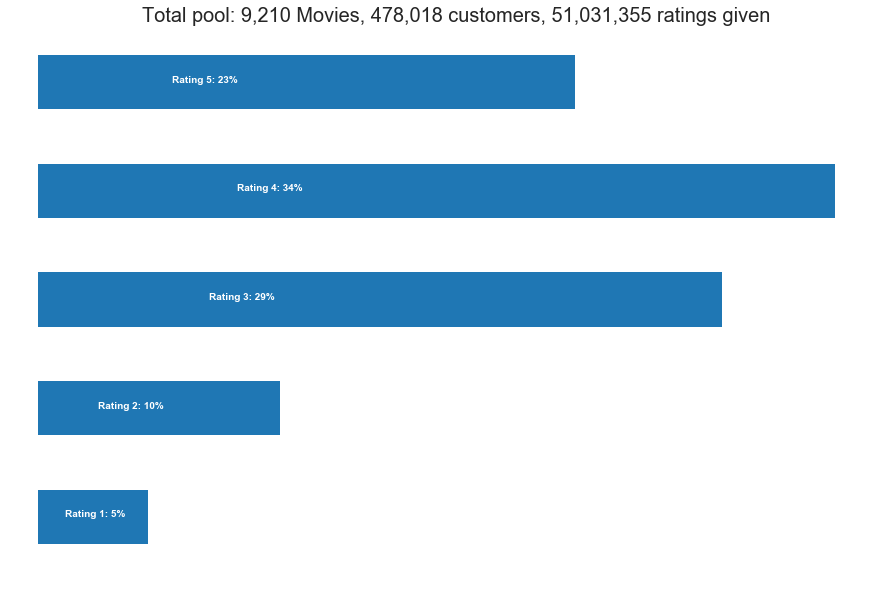

In [5]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')



We can see that the rating tends to be relatively positive (>3). This may be due to the fact that unhappy customers tend to just leave instead of making efforts to rate. We can keep this in mind - low rating movies mean they are generally really bad

## Data cleaning

Movie ID is really a mess import! Looping through dataframe to add Movie ID column WILL make the Kernel run out of memory as it is too inefficient. I achieve my task by first creating a numpy array with correct length then add the whole array as column into the main dataframe! Let's see how it is done below:

In [7]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.00e+00 1.00e+00 1.00e+00 ... 9.21e+03 9.21e+03 9.21e+03]
Length: 51031355


In [8]:
# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])


-Dataset examples-
          Cust_Id  Rating  Movie_Id
1         1488844     3.0         1
5000996    501954     2.0       996
10001962   404654     5.0      1962
15002876   886608     2.0      2876
20003825  1193835     2.0      3825
25004661  1899206     3.0      4661
30005496   154804     4.0      5496
35006274  2078749     5.0      6274
40007057   450763     5.0      7057
45007991   102092     3.0      7991
50009023   220298     5.0      9023


## Data slicing

The data set now is super huge. I have tried many different ways but can't get the Kernel running as intended without memory error. Therefore I tried to reduce the data volumn by improving the data quality below:

* Remove movie with too less reviews (they are relatively not popular)
* Remove customer who give too less reviews (they are relatively less active)

Having above benchmark will have significant improvement on efficiency, since those unpopular movies and non-active customers still occupy same volumn as those popular movies and active customers in the view of matrix (NaN still occupy space). This should help improve the statistical signifiance too.

Let's see how it is implemented:

In [9]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.8),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.8),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 4075.0
Customer minimum times of review: 165.0


Now let's trim down our data, whats the difference in data size?

In [10]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (51031355, 3)
After Trim Shape: (28704854, 3)
-Data Examples-
          Cust_Id  Rating  Movie_Id
5109       785314     1.0         8
8926725   2338809     3.0      1783
17816721  1930076     5.0      3418
26661092  1620184     4.0      4956
35679575  1111322     3.0      6350
44625530   377109     3.0      7904


Let's pivot the data set and put it into a giant matrix - we need it for our recommendation system:

In [11]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)

# Below is another way I used to sparse the dataframe...doesn't seem to work better

#Cust_Id_u = list(sorted(df['Cust_Id'].unique()))
#Movie_Id_u = list(sorted(df['Movie_Id'].unique()))
#data = df['Rating'].tolist()
#row = df['Cust_Id'].astype('category', categories=Cust_Id_u).cat.codes
#col = df['Movie_Id'].astype('category', categories=Movie_Id_u).cat.codes
#sparse_matrix = csr_matrix((data, (row, col)), shape=(len(Cust_Id_u), len(Movie_Id_u)))
#df_p = pd.DataFrame(sparse_matrix.todense(), index=Cust_Id_u, columns=Movie_Id_u)
#df_p = df_p.replace(0, np.NaN)


(95780, 1842)


## Data mapping

Now we load the movie mapping file:

In [19]:
df_title = pd.read_csv('/Users/Yiyi/Documents/Davis/UCD MSBA/Winter/BAX452 Machine Learning /HW7/Input/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


# Recommendation models

Well all data required is loaded and cleaned! Next let's get into the recommendation system.

## Recommend with Collaborative Filtering

Evalute performance of [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering), with just first 100K rows for faster process:

In [20]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:100000], reader)
data.split(n_folds=3)

svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])

/Users/Yiyi/env/lib/python3.6/site-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/Users/Yiyi/env/lib/python3.6/site-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.9871
MAE:  0.7972
------------
Fold 2
RMSE: 0.9856
MAE:  0.7994
------------
Fold 3
RMSE: 0.9799
MAE:  0.7906
------------
------------
Mean RMSE: 0.9842
Mean MAE : 0.7957
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.7971952296623734,
                             0.7994163612464098,
                             0.7906065055144009],
                            'rmse': [0.987149922968697,
                             0.9856484859873026,
                             0.9799123881355363]})

Below is what user 783514 liked in the past:

In [21]:
df_785314 = df[(df['Cust_Id'] == 785314) & (df['Rating'] == 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
print(df_785314)


Movie_Id
175                                        Reservoir Dogs
311                                               Ed Wood
329                                                 Dogma
331                                           Chasing Amy
788                                                Clerks
798                                                  Jaws
907                                       Animal Crackers
985                                             The Mummy
1552                                          Black Adder
1905    Pirates of the Caribbean: The Curse of the Bla...
2000                          Four Weddings and a Funeral
2122                                 Being John Malkovich
2342                                        Super Size Me
2360                                  Singin' in the Rain
2430                           Alien: Collector's Edition
2443                             Like Water for Chocolate
2452        Lord of the Rings: The Fellowship of the Ring
2465 

Let's predict which movies user 785314 would love to watch:

In [23]:
user_785314 = df_title.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.train(trainset)

user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)

user_785314 = user_785314.drop('Movie_Id', axis = 1)

user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))

/Users/Yiyi/env/lib/python3.6/site-packages/surprise/prediction_algorithms/algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


KeyboardInterrupt: 

## Recommend with Pearsons' R correlations

The way it works is we use Pearsons' R correlation to measure the linear correlation between review scores of all pairs of movies, then we provide the top 10 movies with highest correlations:

In [24]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

A recommendation for you if you like 'What the #$*! Do We Know!?'

In [25]:
recommend("What the #$*! Do We Know!?", 0)

For movie (What the #$*! Do We Know!?)
- Top 10 movies recommended based on Pearsons'R correlation - 
PearsonR                                  Name  count      mean
                                                               
1.000000            What the #$*! Do We Know!?  14910  3.189805
0.331558                       The Corporation  11238  3.763125
0.325369          Star Trek: Voyager: Season 5   4175  4.111377
0.322607                      The 10th Kingdom   4532  3.669903
0.317946  Star Trek: Deep Space Nine: Season 5   4373  4.160759
0.309444       To Gillian on her 37th Birthday   4261  3.102793
0.304267      Tales from the Crypt: Deadly Duo   4794  3.183354
0.304156                    Farscape: Season 4   4299  4.356129
0.298833               A Day Without a Mexican   5742  2.401951
0.298145                        Black Adder II   4398  4.056617


X2: X-Men United:

In [26]:
recommend("X2: X-Men United", 0)

For movie (X2: X-Men United)
- Top 10 movies recommended based on Pearsons'R correlation - 
PearsonR                      Name   count      mean
                                                    
1.000000          X2: X-Men United   98720  3.932202
0.342134             Batman Begins   54922  4.236699
0.322815                     Blade   73645  3.640546
0.320934               Constantine   63666  3.406277
0.318258                Underworld   52848  3.556048
0.314869  Mortal Kombat: The Movie    7633  3.165466
0.310967      The Matrix: Reloaded  106807  3.514704
0.302908    Todd McFarlane's Spawn    4684  3.612511
0.296857             Lost in Space   26457  2.915486
0.296307                Species II    7526  2.781424


# ct https://www.kaggle.com/laowingkin/netflix-movie-recommendation I was trying to replicate it by using a bigger dataset

**Recommend with Surprise!**

In [ ]:
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNBaseline

In [ ]:
from surprise import prediction_algorithms

In [ ]:
#i am not sure how to use this